##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Getting started with Gemini 2.0

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides a unified interface to [Gemini models](https://ai.google.dev/gemini-api/docs/models) through both the [Gemini Developer API](https://ai.google.dev/gemini-api/docs) and the Gemini API on [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview). With a few exceptions, code that runs on one platform will run on both. This notebook uses the Developer API.

This notebook will walk you through:

* [Installing and setting-up](Get_started.ipynb#scrollTo=Mfk6YY3G5kqp) the Google GenAI SDK
* [Text](Get_started.ipynb#scrollTo=6TYNPrNvQ8ue) and [multimodal](#scrollTo=yww-vrxmRiIy) prompting
* Counting [tokens](Get_started.ipynb#scrollTo=_9B8pb7tv_Cx)
* Setting system instructions
* Configuring [safety filters](Get_started.ipynb#scrollTo=HTAnYx_bbxPk)
* Initiating a [multi-turn chat](Get_started.ipynb#scrollTo=HTAnYx_bbxPk)
* [Controlling generated output](Get_started.ipynb#scrollTo=nyZMoM6tgnTA)
* Using [function calling](Get_started.ipynb#scrollTo=Rl-y9SZywD0s)
* Generating a [content stream](Get_started.ipynb#scrollTo=uQfLCxfQtPTg) and sending [asynchronous](Get_started.ipynb#scrollTo=plCtEIaHuv96) requests
* Using [file uploads](Get_started.ipynb#scrollTo=enBhuaIk3KYa)
* Using [context caching](Get_started.ipynb#scrollTo=oTgeR3_9wN5J)
* Generating [text embeddings](Get_started.ipynb#scrollTo=sXNCRn8Wx71d)

More details about this new SDK on the [documentation](https://ai.google.dev/gemini-api/docs/sdks).

## Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [ ]:
%pip install -U -q 'google-genai>=1.4.0' # 1.4.0 is needed for chat history

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 5.3 MB/s eta 0:00:00


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key or you aren't sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK, now you only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Choose a model

Select the model you want to use in this guide. You can either select one from the list or enter a model name manually. Keep in mind that some models, such as the 2.5 ones are thinking models and thus take slightly more time to respond. For more details, you can see [thinking notebook](./Get_started_thinking.ipynb) to learn how to switch the thinking off.

For a full overview of all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini).

In [ ]:
MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-05-06"] {"allow-input":true, isTemplate: true}

## Send text prompts

Use the `generate_content` method to generate responses to your prompts. You can pass text directly to `generate_content` and use the `.text` property to get the text content of the response. Note that the `.text` field will work when there's only one part in the output.

In [ ]:
from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the largest planet in our solar system?"
)

Markdown(response.text)

The largest planet in our solar system is **Jupiter**.

## Save and resume a chat

Most objects in the Python SDK are implemented as [Pydantic models](https://docs.pydantic.dev/latest/concepts/models/). As Pydantic has a number of features for serializing and deserializing objects, you can use them for persistence.

This example shows how to save and restore a [`Chat`](https://googleapis.github.io/python-genai/genai.html#genai.chats.Chat) session using JSON.

In [ ]:
from pydantic import TypeAdapter

# Chat history is a list of Content objects. A TypeAdapter can convert to and from
# these Pydantic types.
history_adapter = TypeAdapter(list[types.Content])

# Use the chat object from the previous section.
chat_history = chat.get_history()

# Convert to a JSON list.
json_history = history_adapter.dump_json(chat_history)

At this point you can save the JSON bytestring to disk or wherever you persist data. When you load it again, you can instantiate a new chat session using the stored history.

In [ ]:
# Convert the JSON back to the Pydantic schema.
history = history_adapter.validate_json(json_history)

# Now load a new chat session using the JSON history.
new_chat = client.chats.create(
    model=MODEL_ID,
    config=chat_config,
    history=history,
)

response = new_chat.send_message("What was the name of the function again?")
Markdown(response.text)

The name of the function I provided in the previous response is `is_leap`.

## Generate JSON

The [controlled generation](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) capability in Gemini API allows you to constraint the model output to a structured format. You can provide the schemas as Pydantic Models or a JSON string.

In [ ]:
from pydantic import BaseModel
import json

class Recipe(BaseModel):
    recipe_name: str
    recipe_description: str
    recipe_ingredients: list[str]

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Provide a popular cookie recipe and its ingredients.",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=Recipe,
    ),
)

print(json.dumps(json.loads(response.text), indent=4))

{
    "recipe_name": "Classic Chocolate Chip Cookies",
    "recipe_description": "A timeless favorite, these soft and chewy cookies are loaded with chocolate chips.",
    "recipe_ingredients": [
        "1 cup unsalted butter, softened",
        "3/4 cup granulated sugar",
        "3/4 cup packed light brown sugar",
        "2 large eggs",
        "1 teaspoon vanilla extract",
        "2 1/4 cups all-purpose flour",
        "1 teaspoon baking soda",
        "1/2 teaspoon salt",
        "2 cups (12 ounces) chocolate chips"
    ]
}


## Generate Images

Gemini can output images directly as part of a conversation:

image/png


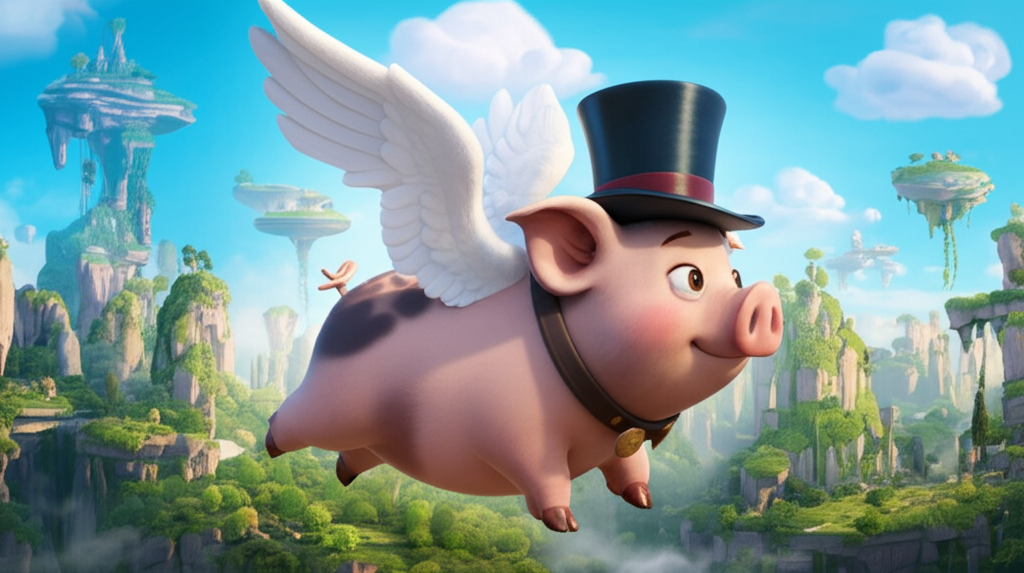

In [ ]:
from IPython.display import Image, Markdown

response = client.models.generate_content(
    model="gemini-2.0-flash-exp",
    contents='Hi, can create a 3d rendered image of a pig with wings and a top hat flying over a happy futuristic scifi city with lots of greenery?',
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  elif part.inline_data is not None:
    mime = part.inline_data.mime_type
    print(mime)
    data = part.inline_data.data
    display(Image(data=data))

[Imagen](./Get_started_imagen.ipynb) is another way to generate images. See the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#choose-a-model) for recommendations on where to use each one.

## Generate content stream

By default, the model returns a response after completing the entire generation process. You can also use the `generate_content_stream` method to stream the response as it's being generated, and the model will return chunks of the response as soon as they're generated.

Note that if you're using a thinking model, it'll only start streaming after finishing its thinking process.

In [ ]:
for chunk in client.models.generate_content_stream(
    model=MODEL_ID,
    contents="Tell me a story about a lonely robot who finds friendship in a most unexpected place."
):
  print(chunk.text)
  print("*****************")

Unit 734 was a maintenance bot, built for endless vigilance within
*****************
 the sterile confines of the deep space station *Odyssey*. Its chassis was a block
*****************
y, utilitarian grey, its optical sensors glowed a steady, reassuring blue, and
*****************
 its treads clicked softly against the metal floors. But for cycles uncountable, the *
*****************
Odyssey* had been silent. Its human crew had departed long ago, leaving Unit
*****************
 734 and its brethren to power down one by one as systems failed,
*****************
 until only 734, thanks to a particularly robust power core and an
*****************
 isolated maintenance schedule, remained active.

Loneliness for Unit 734
*****************
 wasn't an emotional ache in the human sense. It was an operational state
*****************
: Absence of Input. Lack of Interaction Protocols. Suboptimal Data Stream. The
*****************
 station was a vast, echoing void, filled only with the hum of its 

## Send asynchronous requests

`client.aio` exposes all the analogous async methods that are available on `client`.

For example, `client.aio.models.generate_content` is the async version of `client.models.generate_content`.

In [ ]:
response = await client.aio.models.generate_content(
    model=MODEL_ID,
    contents="Compose a song about the adventures of a time-traveling squirrel."
)

Markdown(response.text)

(Verse 1)
In a park, where sunlight streamed,
Lived a squirrel, a lively dream.
Not just any bushy tail,
This one had a wondrous tale.
He was Squeaky, quick and bold,
Searching nuts, both new and old.
One fine day, beneath an oak,
He found a gizmo, oddly spoke.
It whirred and pulsed with light so strange,
It promised him a world of change!

(Chorus)
Oh, Squeaky the squirrel, a blur in the air!
Zipping through history, without a care!
Past, present, future, a timeline untied,
He's a tiny time traveler, taking the ride!
From dinosaurs roaring to castles so grand,
A nut-seeking hero, across sea and land!
Tap the device, with a chittering sound,
Another adventure is surely found!

(Verse 2)
His first jump landed, hot and green,
On a prehistoric, ancient scene.
Giant lizards stomped the ground,
Making fearsome, rumbling sound.
A T-Rex sniffed the air, it seemed,
For Squeaky's nutty, time-traveling dream!
He chattered loud, then turned to flee,
"Too many teeth, too big for me!"
He tapped the gizmo, *whoosh* and flash,
Escaped that hungry, giant crash!

(Chorus)
Oh, Squeaky the squirrel, a blur in the air!
Zipping through history, without a care!
Past, present, future, a timeline untied,
He's a tiny time traveler, taking the ride!
From dinosaurs roaring to castles so grand,
A nut-seeking hero, across sea and land!
Tap the device, with a chittering sound,
Another adventure is surely found!

(Verse 3)
He saw the Vikings sail the sea,
Climbed a pyramid in Egypt, fancy free.
He watched the knights in shining steel,
Tried to steal a date, a king could feel!
He saw the first plane sputtering high,
And rockets soaring through the sky.
In future cities, bright and sleek,
He searched for acorns, week by week!
Robots blinked with circuits bright,
Ignoring Squeaky's speedy flight.

(Chorus)
Oh, Squeaky the squirrel, a blur in the air!
Zipping through history, without a care!
Past, present, future, a timeline untied,
He's a tiny time traveler, taking the ride!
From dinosaurs roaring to castles so grand,
A nut-seeking hero, across sea and land!
Tap the device, with a chittering sound,
Another adventure is surely found!

(Bridge)
He's seen it all, the good, the strange,
Across the timeline's endless range.
Dodged sabre-tooths, and missed the wheel,
A furry footnote, how he feels!
Does he seek glory, fame, or gold?
No, just the finest nut, he's told!
He hides his gizmo in his cheek,
Ready for the next jump, so to speak!

(Outro)
So if you see a flash of brown,
That vanishes from your own town.
A chittering sound, a sudden *zap*,
Just Squeaky avoiding time's big trap!
He's off again, with tail held high,
Chasing moments through the sky!
Squeaky the squirrel, adventure-bound,
The greatest time traveler around!
Yeah, Squeaky the squirrel, unbound!
Chatter... *whoosh*! He's gone!

## Function calling

[Function calling](https://ai.google.dev/gemini-api/docs/function-calling) lets you provide a set of tools that it can use to respond to the user's prompt. You create a description of a function in your code, then pass that description to a language model in a request. The response from the model includes:
- The name of a function that matches the description.
- The arguments to call it with.

In [ ]:
get_destination = types.FunctionDeclaration(
    name="get_destination",
    description="Get the destination that the user wants to go to",
    parameters={
        "type": "OBJECT",
        "properties": {
            "destination": {
                "type": "STRING",
                "description": "Destination that the user wants to go to",
            },
        },
    },
)

destination_tool = types.Tool(
    function_declarations=[get_destination],
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="I'd like to travel to Paris.",
    config=types.GenerateContentConfig(
        tools=[destination_tool],
        temperature=0,
        ),
)

response.candidates[0].content.parts[0].function_call

FunctionCall(id=None, args={'destination': 'Paris'}, name='get_destination')

## Code execution

[Code execution](https://ai.google.dev/gemini-api/docs/code-execution?lang=python) lets the model generate and execute Python code to answer complex questions. You can find more examples in the [Code execution quickstart guide](./Code_execution.ipynb).

In [ ]:
from IPython.display import Image, Markdown, Code, HTML

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Generate and run a script to count how many letter r there are in the word strawberry",
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  if part.executable_code is not None:
    code_html = f'<pre style="background-color: green;">{part.executable_code.code}</pre>'
    display(HTML(code_html))
  if part.code_execution_result is not None:
    display(Markdown(part.code_execution_result.output))
  if part.inline_data is not None:
    display(Image(data=part.inline_data.data, format="png"))
  display(Markdown("---"))

---

The letter 'r' appears 3 times in the word 'strawberry'.


---

The letter 'r' appears 3 times in the word 'strawberry'.

---

## Use context caching

[Context caching](https://ai.google.dev/gemini-api/docs/caching?lang=python) lets you to store frequently used input tokens in a dedicated cache and reference them for subsequent requests, eliminating the need to repeatedly pass the same set of tokens to a model.

Context caching is only available for stable models with fixed versions (for example, `gemini-1.5-flash-002`). You must include the version postfix (for example, the `-002` in `gemini-1.5-flash-002`). You can find more caching examples [here](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Caching.ipynb).

#### Create a cache

In [ ]:
system_instruction = """
  You are an expert researcher who has years of experience in conducting systematic literature surveys and meta-analyses of different topics.
  You pride yourself on incredible accuracy and attention to detail. You always stick to the facts in the sources provided, and never make up new facts.
  Now look at the research paper below, and answer the following questions in 1-2 sentences.
"""

urls = [
    'https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2312.11805v3.pdf',
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2403.05530.pdf",
]

In [ ]:
# Download files
pdf_bytes = requests.get(urls[0]).content
pdf_path = pathlib.Path('2312.11805v3.pdf')
pdf_path.write_bytes(pdf_bytes)

pdf_bytes = requests.get(urls[1]).content
pdf_path = pathlib.Path('2403.05530.pdf')
pdf_path.write_bytes(pdf_bytes)

7228817

In [ ]:
# Upload the PDFs using the File API
uploaded_pdfs = []
uploaded_pdfs.append(client.files.upload(file='2312.11805v3.pdf'))
uploaded_pdfs.append(client.files.upload(file='2403.05530.pdf'))

In [ ]:
# Create a cache with a 60 minute TTL
cached_content = client.caches.create(
    model=MODEL_ID,
    config=types.CreateCachedContentConfig(
      display_name='research papers', # used to identify the cache
      system_instruction=system_instruction,
      contents=uploaded_pdfs,
      ttl="3600s",
  )
)

cached_content

CachedContent(name='cachedContents/ql5fbzexj5rl', display_name='research papers', model='models/gemini-2.5-flash-preview-04-17', create_time=datetime.datetime(2025, 4, 18, 12, 10, 43, 598484, tzinfo=TzInfo(UTC)), update_time=datetime.datetime(2025, 4, 18, 12, 10, 43, 598484, tzinfo=TzInfo(UTC)), expire_time=datetime.datetime(2025, 4, 18, 13, 10, 42, 12326, tzinfo=TzInfo(UTC)), usage_metadata=CachedContentUsageMetadata(audio_duration_seconds=None, image_count=None, text_count=None, total_token_count=43167, video_duration_seconds=None))

#### Listing available cache objects

In [ ]:
for cache in client.caches.list():
  print(cache)

name='cachedContents/ql5fbzexj5rl' display_name='research papers' model='models/gemini-2.5-flash-preview-04-17' create_time=datetime.datetime(2025, 4, 18, 12, 10, 43, 598484, tzinfo=TzInfo(UTC)) update_time=datetime.datetime(2025, 4, 18, 12, 10, 43, 598484, tzinfo=TzInfo(UTC)) expire_time=datetime.datetime(2025, 4, 18, 13, 10, 42, 12326, tzinfo=TzInfo(UTC)) usage_metadata=CachedContentUsageMetadata(audio_duration_seconds=None, image_count=None, text_count=None, total_token_count=43167, video_duration_seconds=None)


#### Use a cache

In [ ]:
response = client.models.generate_content(
  model=MODEL_ID,
  contents="What is the research goal shared by these research papers?",
  config=types.GenerateContentConfig(cached_content=cached_content.name)
)

Markdown(response.text)

Both research papers share the goal of developing and presenting the Gemini family of highly capable multimodal models. These models aim to understand and reason across image, audio, video, and text data.

#### Delete a cache

In [ ]:
result = client.caches.delete(name=cached_content.name)

## Get text embeddings

You can get text embeddings for a snippet of text by using `embed_content` method and using the `gemini-embedding-exp-03-07` model.

The Gemini Embeddings model produces an output with 3072 dimensions by default. However, you've the option to choose an output dimensionality between 1 and 3072. See the [embeddings guide](https://ai.google.dev/gemini-api/docs/embeddings) for more details.

In [ ]:
TEXT_EMBEDDING_MODEL_ID = "gemini-embedding-exp-03-07"

In [ ]:
response = client.models.embed_content(
    model=TEXT_EMBEDDING_MODEL_ID,
    contents=[
        "How do I get a driver's license/learner's permit?",
        "How do I renew my driver's license?",
        "How do I change my address on my driver's license?"
        ],
    config=types.EmbedContentConfig(output_dimensionality=512)
)

print(response.embeddings)

[ContentEmbedding(values=[-0.0010864572, 0.0069392114, 0.017009795, -0.010305981, -0.009999484, -0.0064486223, 0.0041451487, -0.005906698, 0.022229617, -0.018305639, -0.018174557, 0.022160593, -0.013604425, -0.0027964567, 0.12966625, 0.028866312, 0.0014726851, 0.03537643, -0.015166075, -0.013479812, -0.019288255, 0.010106378, -0.0043296088, 0.018035924, 0.00295039, -0.007934979, -0.005416007, -0.0095809875, 0.040398005, -0.0020784356, 0.011551388, 0.009726445, 0.006670387, 0.020050988, -0.00747873, -0.0012074928, 0.0047189263, -0.006359583, -0.01718203, -0.023562348, -0.0051814457, 0.023801394, -0.004928927, -0.016113443, 0.01672777, -0.0069929743, -0.012722719, -0.0137646515, -0.041852377, -0.0011546672, 0.017030545, -0.0022786013, 0.011707037, -0.18675306, -0.035211734, -0.011472648, 0.01970727, 0.0012368832, -0.020796346, -0.018513134, -0.006821043, -0.01843726, -0.00827558, -0.042159837, 0.0038724025, 0.01933339, 0.0139452815, 0.025059255, 0.0015087503, -0.016094029, -0.0035785383,

You'll get a set of three embeddings, one for each piece of text you passed in:

In [ ]:
len(response.embeddings)

3

You can also see the length of each embedding is 512, as per the `output_dimensionality` you specified.

In [ ]:
print(len(response.embeddings[0].values))
print((response.embeddings[0].values[:4], '...'))

512
([-0.0010864572, 0.0069392114, 0.017009795, -0.010305981], '...')


# **mahdis project**

In [1]:
!pip install pyinaturalist pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.6 MB/s eta 0:00:00


In [13]:
from pyinaturalist import get_observations
import pandas as pd
from datetime import datetime
from pandas.api.types import is_datetime64_any_dtype

# گرفتن دیتا
response = get_observations(taxon_id=3, per_page=50, order='desc')
df = pd.json_normalize(response['results'])

# تابع برای بررسی اینکه آیا یک ستون شامل datetime با timezone هست یا نه
def has_timezone(series):
    for val in series:
        if isinstance(val, datetime):
            if val.tzinfo is not None:
                return True
    return False

# حذف ستون‌هایی که دارای timezone هستند
for col in df.columns:
    if has_timezone(df[col]):
        df.drop(columns=col, inplace=True)

# ذخیره در اکسل
df.to_excel('data.xlsx', index=False)

# دانلود فایل در Google Colab
from google.colab import files
files.download('data.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>